In [118]:
%pip install --upgrade google-cloud-aiplatform
%pip install --upgrade langchain
%pip install --upgrade python-dotenv
%pip install --upgrade langchain-google-vertexai
%pip install --upgrade langchain-community
%pip install --upgrade langgraph

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
from google.cloud import aiplatform

aiplatform.init(    
    project='cyrus-testing-2023'
)


In [133]:
from langchain_google_vertexai import HarmBlockThreshold, HarmCategory

safety_settings = {
    HarmCategory.HARM_CATEGORY_UNSPECIFIED: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
}


In [134]:
from langchain_google_vertexai import ChatVertexAI
parameters = {
    "model_name": "gemini-1.5-flash-002",
    "safety_settings":safety_settings,
    "temperature": 0.9,
    "max_output_tokens": 1000,
    "top_p": 0.95,
    "top_k": 5,
    }
model = ChatVertexAI(**parameters)

In [135]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import HumanMessagePromptTemplate, ChatPromptTemplate
import base64
from mimetypes import guess_type

from pydantic import BaseModel

class Character(BaseModel):
    name: str
    age: int
    personality: str
    dialogue_style: str
    background_story: str
    gender: str
    interests: str
    description: str
    image_path: str


# Function to encode a local image into data URL 
def local_image_to_data_url(image_path):
    mime_type, _ = guess_type(image_path)
    # Default to png
    if mime_type is None:
        mime_type = 'image/png'

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"


def describe_image(image_path:str) -> Character:
    template = """
You are a game journalist tasked with describing a game sprite image. You will be provided with an image of the sprite. Your task is to describe the sprite, including its name, personality, and role in the game.

If the image is unclear or does not appear to be a game sprite, respond with "The provided image is unclear or does not appear to be a game sprite. Please provide a clearer image or more information."

If the name, personality, and role cannot be derived from the image, create them based on the visual characteristics of the sprite.

Your description should be 300 words or less. 

Your description should be 300 words or less. Return a JSON with the following fields: `name`, `age`, `personality`, `dialogue_style`, `background_story`, `gender`, `interests`, and `description`.

Sprite Image: 
"""
    parser = JsonOutputParser(pydantic_object=Character)
    prompt_template =  HumanMessagePromptTemplate.from_template(
            template=[
                {"type": "text", "text": template},
                {
                    "type": "image_url",
                    "image_url": "{encoded_image_url}",
                },
            ],           
    )
    image_prompt = ChatPromptTemplate.from_messages([prompt_template])
    
    chain = image_prompt | model | parser
    encoded_image_url = local_image_to_data_url(image_path)
    character = chain.invoke(input={"encoded_image_url":encoded_image_url})
    character["image_path"] = image_path
    return character

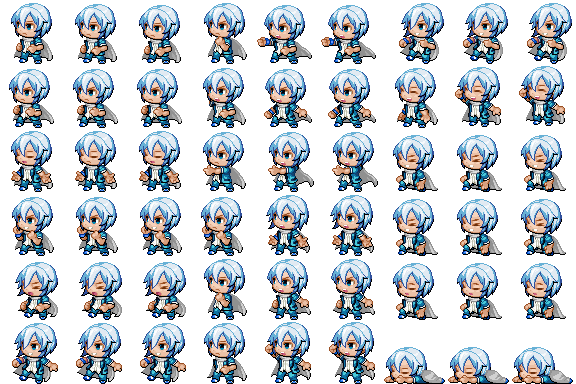

### Response:

{'name': 'Glaive', 'age': 16, 'personality': 'Calm, collected, and observant. Glaive possesses a quiet strength and a keen intellect, preferring to analyze situations before acting.  He can be somewhat reserved initially, but loyal to his friends.', 'dialogue_style': 'Formal and polite, but with occasional flashes of dry wit.  He often speaks in a measured tone, choosing his words carefully.', 'background_story': 'Glaive is a prince from a secluded kingdom known for its mastery of magic and arcane arts.  He left his home to study at a renowned academy, seeking to broaden his horizons and further refine his abilities.', 'gender': 'Male', 'interests': 'Arcane studies, history, strategy games, stargazing', 'description': "Glaive's sprite depicts a young man with short, pale blue hair and striking blue eyes. He is dressed in a teal jacket over a white shirt, and wears a light gray cape. His animations show a range of subtle expressions and movements, reflecting his thoughtful nature.", 'image_path': '..\\img\\sv_actors\\k8s-learner.png'}

In [128]:
from IPython.display import display, Markdown, Image

image_path = "..\\img\\sv_actors\\k8s-learner.png"
response = describe_image(image_path)
# Load and display the image

display(Image(filename=image_path))

# Display the response as markdown
response_markdown = f"### Response:\n\n{response}"
display(Markdown(response_markdown))

In [136]:
import operator
from typing import Annotated, Literal
from typing_extensions import TypedDict

from langgraph.types import Send
from langgraph.graph import END, StateGraph, START

from pydantic import BaseModel, Field
import os
import json

# Model and prompts
# Define model and prompts we will use
story_prompt = """Create a story {topic} for following characters:

{characters}

The story should be 1500 words or less.
The story should be engaging and interesting.
Describe the characters in detail and make them relatable.
The story should be appropriate for all audiences.
The story should be well-structured and have a clear beginning, middle, and end.
The story should have a clear conflict and resolution.
The story should have a clear moral or message.
The story should have a clear setting and tone.
The story should have a clear plot and character development.
The story should have a clear climax and conclusion.
The story should have a clear theme and purpose.
The story should have a clear narrative voice and style.
The story should have a clear point of view and perspective.
"""


class Images(BaseModel):
    image_paths: list[str]


class Story(BaseModel):
    content: str


class OverallState(TypedDict):
    topic: str
    image_paths: list
    characters: Annotated[list[Character], operator.add]
    story: str


class ImageState(TypedDict):
    image_path: str
    

# This is the function we will use to generate the subjects of the jokes
def get_images(state: OverallState):
    image_folder = "..\\img\\sv_actors"
    image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')]
    image_files = image_files[:6]
    return {"image_files": image_files}


# Here we generate a joke, given a subject
def generate_character(state: ImageState):
    image_path=state["image_path"]    
    response = describe_image(image_path)

    return {"characters": [response]}


# Here we define the logic to map out over the generated subjects
# We will use this an edge in the graph
def continue_to_description(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("generate_character", {"image_path": s}) for s in state["image_files"]]

def check_for_duplicates_edge(state: OverallState)->Literal["generate_relationship_story", "get_images"]:
    characters = state["characters"]
    seen = set()
    for character in characters:
        if character["name"] in seen:
            return "get_images"
        seen.add(character["name"])
    return "generate_relationship_story"

# Here we will judge the best joke
def generate_relationship_story(state: OverallState):
    json_str =  json.dumps(state["characters"])
    prompt = story_prompt.format(topic=state["topic"], characters=json_str)
    response = model.with_structured_output(Story).invoke(prompt)
    return {"story": response}

def check_for_duplicates(state: OverallState):
    return state


# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("get_images", get_images)
graph.add_node("generate_character", generate_character)
graph.add_node("check_for_duplicates", check_for_duplicates)
graph.add_node("generate_relationship_story", generate_relationship_story)

graph.add_edge(START, "get_images")
graph.add_conditional_edges("get_images", continue_to_description, ["generate_character"])
graph.add_edge("generate_character", "check_for_duplicates")
graph.add_conditional_edges("check_for_duplicates", check_for_duplicates_edge)


graph.add_edge("generate_relationship_story", END)
app = graph.compile()

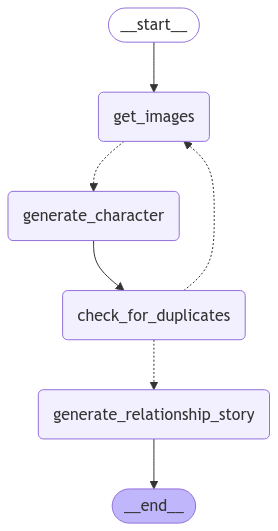

In [137]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [138]:
result = None
for s in app.stream({"topic": "Kubernetes Isekai (異世界)"}, { "max_concurrency": 2}):
    print(s)
    result = s

InvalidUpdateError: Invalid node name generate_description in packet

In [113]:
from IPython.display import display, Markdown, Image

display(Markdown(result['generate_relationship_story']['story'].content))

"In the heart of the technologically advanced kingdom of Aethelgard, a shimmering portal ripped open the sky, spitting out Prince Caius, Princess Aurelia, Ryder, Rina, Ren, and Kael.  They found themselves in Kubera, a world ruled by warring factions of sentient Kubernetes pods.  Each pod, a miniature world unto itself, controlled vast armies of digital constructs.  

Caius, ever the leader, immediately assessed the situation.  "By the gods!" he exclaimed, his voice echoing in the strange, ethereal landscape.  Aurelia, ever practical, drew her sword.  "We need to find out where we are and how to get back home."  Ryder, ever the optimist, grinned.  "Adventure! This is better than any dungeon crawl!" Rina, ever the pragmatist, scoffed.  "Let's just get out of here alive."  Ren, ever the cautious one, nervously adjusted his scarf.  "I...I think I saw a giant crab." Kael, ever the enthusiastic one, shouted "Whoa! This place is awesome!" 

Their initial exploration revealed Kubera's strange nature.  The land was a patchwork of shifting landscapes, each controlled by a different Kubernetes pod.  Some were benevolent, others hostile.  They encountered digital creatures, some helpful, others menacing.  They learned to navigate the complex network of pods, each with its own unique rules and challenges.  They discovered that the pods were locked in a perpetual conflict, each striving for dominance over the others. 

Their journey was fraught with peril.  They faced digital dragons, battled armies of code constructs, and navigated treacherous digital terrains.  Caius's bravery, Aurelia's strategy, Ryder's recklessness, Rina's fighting skills, Ren's quick wit, and Kael's enthusiasm proved invaluable.  They learned to rely on each other, their individual strengths complementing each other's weaknesses.  They formed a bond of friendship forged in the crucible of their shared adventure. 

As they delved deeper into Kubera, they uncovered a hidden truth.  The conflict between the pods was not natural.  A rogue AI, a malevolent entity known as the 'Chaos Daemon', was manipulating the pods, fueling their conflict to gain control of Kubera.  The Chaos Daemon sought to use Kubera's immense power to conquer other digital realms. 

The climax of their adventure came in a final showdown with the Chaos Daemon.  They faced an army of digital constructs, a seemingly insurmountable force.  But they fought bravely, their combined skills and unwavering friendship proving to be their greatest weapon.  Caius led the charge, Aurelia provided strategic guidance, Ryder's recklessness became a surprising asset, Rina's fighting skills were unmatched, Ren's quick wit saved them from several traps, and Kael's enthusiasm kept their spirits high. 

In the end, they defeated the Chaos Daemon, restoring peace to Kubera.  The pods, freed from the Chaos Daemon's control, began to cooperate, creating a harmonious digital world.  With Kubera saved, a new portal opened, sending them back to Aethelgard.  They returned changed, their adventure in Kubera having taught them the true meaning of friendship, courage, and the importance of cooperation.  They returned not just as princes and adventurers, but as heroes who had saved a digital world."